<a href="https://colab.research.google.com/github/SergeyShchus/Satellite-Imagery-Analysis-with-Python/blob/master/jupyter-notebooks/Detecting_Changes_in_Sentinel_1_Imagery_Liman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=__Q2EemNFDuNswSsG_exPfabvi_u1FCPhK4-JJGdkc4&tc=DBJvwvy35aUvPq4CNIvLgUF9cL1thwvnMNAQfz__cMI&cc=QhR4dWVQ4R6BmgmxVhqZ9dT0aVfNmFpD7q-I0b3jWBo

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWgLRnXC5MK4VVlGLdvEQKlpJwqew3kcs41foW-QJK4HvRQzV4159xI

Successfully saved authorization token.


In [49]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm, gamma, f, chi2
import IPython.display as disp
%matplotlib inline

In [50]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [51]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              37.718467712402344,
              49.02481224812418
            ],
            [
              37.71984100341797,
              48.93964118139728
            ],
            [
              37.87914276123047,
              48.93716047863997
            ],
            [
              37.872962951660156,
              49.03314127821165
            ],
            [
              37.718467712402344,
              49.02481224812418
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              37.718467712402344,
              49.02481224812418
            ],
            [
              37.71984100341797,
              48.93964118139728
            ],
            [
              37.87914276123047,
              48.93716047863997
            ],
            [
              37.872962951660156,
              49.03314127821165
            ],
            [
              37.718467712402344,
              49.02481224812418
            ]
          ]
        ]
      }
    }
  ]
}
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi_sub = ee.Geometry.Polygon(coords)

In [52]:
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD')
                .filterBounds(aoi)
                .filterDate(ee.Date('2022-04-20'),ee.Date('2022-05-24'))
                .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                #.filter(ee.Filter.eq('relativeOrbitNumber_start', 15))
                .sort('system:time_start'))

In [53]:
import time
acq_times = im_coll.aggregate_array('system:time_start').getInfo()
[time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

['04/24/22', '04/29/22', '05/06/22', '05/11/22', '05/18/22', '05/23/22']

In [54]:
im_list = im_coll.toList(im_coll.size())
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi_sub)
im2 = ee.Image(im_list.get(5)).select('VV').clip(aoi_sub)

In [55]:
ratio = im1.divide(im2)
url = ratio.getThumbURL({'min': 0, 'max': 10})
disp.Image(url=url, width=800)

In [56]:
hist = ratio.reduceRegion(ee.Reducer.fixedHistogram(0, 5, 500), aoi_sub).get('VV').getInfo()
mean = ratio.reduceRegion(ee.Reducer.mean(), aoi_sub).get('VV').getInfo()
variance = ratio.reduceRegion(ee.Reducer.variance(), aoi_sub).get('VV').getInfo()

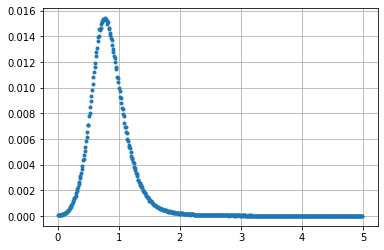

In [57]:
a = np.array(hist)
x = a[:, 0]
y = a[:, 1] / np.sum(a[:, 1])
plt.grid()
plt.plot(x, y, '.')
plt.show()

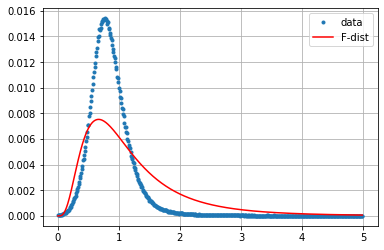

In [58]:
m = 5
plt.grid()
plt.plot(x, y, '.', label='data')
plt.plot(x, f.pdf(x, 2*m, 2*m) / 100, '-r', label='F-dist')
plt.legend()
plt.show()

In [59]:
print(mean, m/(m-1))
print(variance, m*(2*m-1)/(m-1)**2/(m-2))

0.8618825607578905 1.25
4379.71126697742 0.9375


In [60]:
im1 = ee.Image(im_list.get(0)).select('VV').clip(aoi)
im2 = ee.Image(im_list.get(1)).select('VV').clip(aoi)
ratio = im1.divide(im2)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=12)
mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_child(folium.LayerControl())

display(mp)

In [70]:
# Decision threshold alpha/2:
dt = f.ppf(0.0005, 2*m, 2*m)

# LRT statistics.
q1 = im1.divide(im2)
q2 = im2.divide(im1)

# Change map with 0 = no change, 1 = decrease, 2 = increase in intensity.
c_map = im1.multiply(0).where(q2.lt(dt), 1)
c_map = c_map.where(q1.lt(dt), 2)

# Mask no-change pixels.
c_map = c_map.updateMask(c_map.gt(0))

# Display map with red for increase and blue for decrease in intensity.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='Stamen Toner',
    zoom_start=13)
folium.TileLayer('OpenStreetMap').add_to(mp)

folium.GeoJson(gdf[:1000], style_function=lambda x: style_buildings).add_to(mp)

mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 'palette': ['black', 'blue', 'red']},
                'Change Map')
mp.add_child(folium.LayerControl())


display(mp)

In [62]:
!pip install osmnx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
import matplotlib.pyplot as plt
import osmnx as ox

%matplotlib inline
ox.__version__

'1.1.2'

In [64]:
place1 = "Liman, Ukraine"
G = ox.graph_from_place(place1, network_type="drive")
gdf = ox.geometries_from_place(place1, {"building": True})

/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):
/usr/local/lib/python3.7/dist-packages/osmnx/geometries.py:805: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  for merged_outer_linestring in list(merged_outer_linestrings):


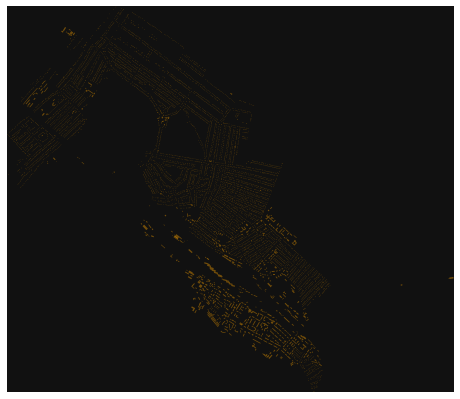

In [65]:
# or plot street network and the entities' footprints together
fig, ax = ox.plot_footprints(gdf, alpha=0.4, show=False)
#fig, ax = ox.plot_graph(G, ax=ax, node_size=0, edge_color="w", edge_linewidth=0.7)

In [71]:
# Decision threshold alpha/2:
dt = f.ppf(0.0005, 2*m, 2*m)

# LRT statistics.
q1 = im1.divide(im2)
q2 = im2.divide(im1)

# Change map with 0 = no change, 1 = decrease, 2 = increase in intensity.
c_map = im1.multiply(0).where(q2.lt(dt), 1)
c_map = c_map.where(q1.lt(dt), 2)

# Mask no-change pixels.
c_map = c_map.updateMask(c_map.gt(0))

# Display map with red for increase and blue for decrease in intensity.
location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(
    location=location, tiles='Stamen Toner',
    zoom_start=13)
folium.TileLayer('OpenStreetMap').add_to(mp)
style_buildings = {'color':'#6C3483', 'fillColor': '#6C3483'}
folium.GeoJson(gdf[:1000], style_function=lambda x: style_buildings).add_to(mp)

mp.add_ee_layer(ratio,
                {'min': 0, 'max': 20, 'palette': ['black', 'white']}, 'Ratio')
mp.add_ee_layer(c_map,
                {'min': 0, 'max': 2, 'palette': ['black', 'blue', 'red']},
                'Change Map')
mp.add_child(folium.LayerControl())


display(mp)

In [39]:
gdf.shape

(7776, 36)

In [44]:
style_buildings = {'color':'#6C3483', 'fillColor': '#6C3483', 'weight':'1', 'fillOpacity' : 1}
m = folium.Map([ 57.70958, 11.96687],
zoom_start=15,
tiles="Stamen Toner")
folium.GeoJson(gdf[:1000], style_function=lambda x: style_buildings).add_to(m)
m